# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

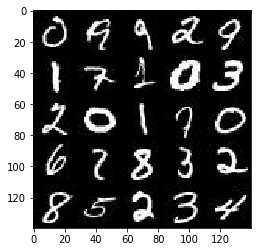

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

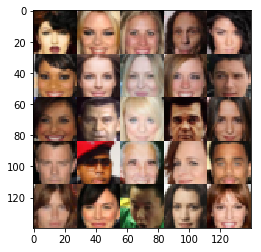

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [19]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 14x14x64
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.7)
        # 14x14x128
        
        x2 = tf.layers.conv2d(x1, 256, 5, strides=1, padding="same",
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.dropout(x2, 0.7)
        # 7x7x256
        
        x3 = tf.layers.conv2d(x2, 512, 5, strides=2, padding="same",
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.dropout(x3, 0.7)
        # 7x7x512
        
        # Flatten
        flat = tf.reshape(x3, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [20]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.8)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.8)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.8)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
    
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, input_lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, input_lr, beta1)
    steps = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Resize images ( -1 to 1)
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                
                if steps % 10 == 0 or steps == 1:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0 or steps == 1:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
        show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
        print("Done");

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3103... Generator Loss: 0.6738


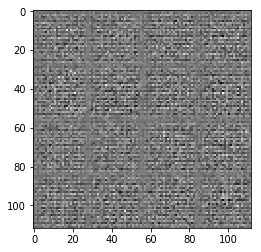

Epoch 1/2... Discriminator Loss: 3.8142... Generator Loss: 0.1799
Epoch 1/2... Discriminator Loss: 2.2789... Generator Loss: 4.0458
Epoch 1/2... Discriminator Loss: 1.4740... Generator Loss: 0.7901
Epoch 1/2... Discriminator Loss: 1.8864... Generator Loss: 2.7772
Epoch 1/2... Discriminator Loss: 1.0617... Generator Loss: 1.4615
Epoch 1/2... Discriminator Loss: 1.5366... Generator Loss: 0.5545
Epoch 1/2... Discriminator Loss: 1.7977... Generator Loss: 1.9434
Epoch 1/2... Discriminator Loss: 1.2877... Generator Loss: 1.5828
Epoch 1/2... Discriminator Loss: 1.2574... Generator Loss: 0.8738
Epoch 1/2... Discriminator Loss: 1.5082... Generator Loss: 0.8418


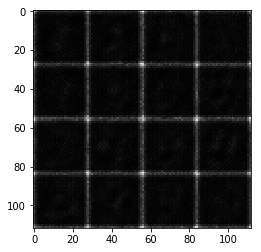

Epoch 1/2... Discriminator Loss: 1.4363... Generator Loss: 1.5943
Epoch 1/2... Discriminator Loss: 1.5720... Generator Loss: 0.7121
Epoch 1/2... Discriminator Loss: 1.0587... Generator Loss: 1.2354
Epoch 1/2... Discriminator Loss: 1.2040... Generator Loss: 1.4484
Epoch 1/2... Discriminator Loss: 1.4479... Generator Loss: 1.7465
Epoch 1/2... Discriminator Loss: 2.5669... Generator Loss: 2.9778
Epoch 1/2... Discriminator Loss: 1.3105... Generator Loss: 1.0555
Epoch 1/2... Discriminator Loss: 1.1086... Generator Loss: 1.5520
Epoch 1/2... Discriminator Loss: 0.9684... Generator Loss: 1.8008
Epoch 1/2... Discriminator Loss: 1.4840... Generator Loss: 0.6980


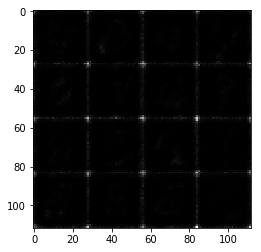

Epoch 1/2... Discriminator Loss: 1.0765... Generator Loss: 1.1691
Epoch 1/2... Discriminator Loss: 1.1330... Generator Loss: 1.0696
Epoch 1/2... Discriminator Loss: 1.2078... Generator Loss: 2.0885
Epoch 1/2... Discriminator Loss: 0.9668... Generator Loss: 2.1280
Epoch 1/2... Discriminator Loss: 1.1496... Generator Loss: 1.1819
Epoch 1/2... Discriminator Loss: 1.4605... Generator Loss: 1.8116
Epoch 1/2... Discriminator Loss: 1.2101... Generator Loss: 2.1991
Epoch 1/2... Discriminator Loss: 1.1776... Generator Loss: 1.7771
Epoch 1/2... Discriminator Loss: 1.1186... Generator Loss: 1.2243
Epoch 1/2... Discriminator Loss: 1.0891... Generator Loss: 1.8997


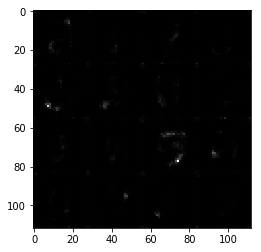

Epoch 1/2... Discriminator Loss: 1.2375... Generator Loss: 2.5366
Epoch 1/2... Discriminator Loss: 1.0780... Generator Loss: 1.1355
Epoch 1/2... Discriminator Loss: 1.3596... Generator Loss: 0.7427
Epoch 1/2... Discriminator Loss: 1.0870... Generator Loss: 1.6208
Epoch 1/2... Discriminator Loss: 1.0333... Generator Loss: 1.7857
Epoch 1/2... Discriminator Loss: 0.9962... Generator Loss: 1.1634
Epoch 1/2... Discriminator Loss: 1.0361... Generator Loss: 1.2174
Epoch 1/2... Discriminator Loss: 1.2740... Generator Loss: 1.1446
Epoch 1/2... Discriminator Loss: 1.1805... Generator Loss: 1.1806
Epoch 1/2... Discriminator Loss: 1.1872... Generator Loss: 1.4160


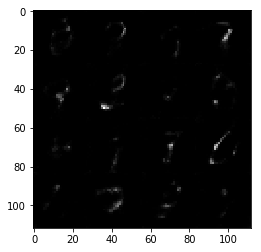

Epoch 1/2... Discriminator Loss: 1.6015... Generator Loss: 2.5302
Epoch 1/2... Discriminator Loss: 1.3439... Generator Loss: 2.6689
Epoch 1/2... Discriminator Loss: 1.1262... Generator Loss: 1.4664
Epoch 1/2... Discriminator Loss: 1.0725... Generator Loss: 2.0072
Epoch 1/2... Discriminator Loss: 0.9679... Generator Loss: 1.5872
Epoch 1/2... Discriminator Loss: 1.2304... Generator Loss: 2.0603
Epoch 1/2... Discriminator Loss: 1.1154... Generator Loss: 0.9120
Epoch 1/2... Discriminator Loss: 0.9997... Generator Loss: 1.1877
Epoch 1/2... Discriminator Loss: 1.1280... Generator Loss: 0.9807
Epoch 1/2... Discriminator Loss: 1.0449... Generator Loss: 1.0647


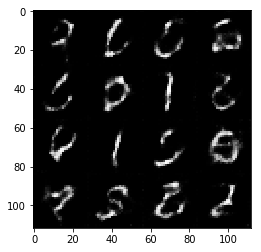

Epoch 1/2... Discriminator Loss: 1.6138... Generator Loss: 0.5577
Epoch 1/2... Discriminator Loss: 1.0939... Generator Loss: 1.8111
Epoch 1/2... Discriminator Loss: 1.1438... Generator Loss: 1.0731
Epoch 1/2... Discriminator Loss: 1.7452... Generator Loss: 0.6183
Epoch 1/2... Discriminator Loss: 1.1044... Generator Loss: 0.9987
Epoch 1/2... Discriminator Loss: 1.2533... Generator Loss: 1.2751
Epoch 1/2... Discriminator Loss: 1.0454... Generator Loss: 1.0291
Epoch 1/2... Discriminator Loss: 1.1730... Generator Loss: 1.3612
Epoch 1/2... Discriminator Loss: 1.1452... Generator Loss: 1.0085
Epoch 1/2... Discriminator Loss: 1.2011... Generator Loss: 1.3633


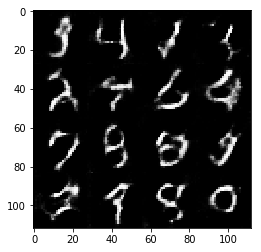

Epoch 1/2... Discriminator Loss: 1.5807... Generator Loss: 2.7576
Epoch 1/2... Discriminator Loss: 1.4250... Generator Loss: 0.5806
Epoch 1/2... Discriminator Loss: 1.2352... Generator Loss: 1.1707
Epoch 1/2... Discriminator Loss: 1.2517... Generator Loss: 0.5752
Epoch 1/2... Discriminator Loss: 1.2641... Generator Loss: 0.7889
Epoch 1/2... Discriminator Loss: 1.1592... Generator Loss: 1.1744
Epoch 1/2... Discriminator Loss: 1.1127... Generator Loss: 1.5822
Epoch 1/2... Discriminator Loss: 1.3039... Generator Loss: 0.6373
Epoch 1/2... Discriminator Loss: 1.0553... Generator Loss: 1.9942
Epoch 1/2... Discriminator Loss: 0.9920... Generator Loss: 1.5029


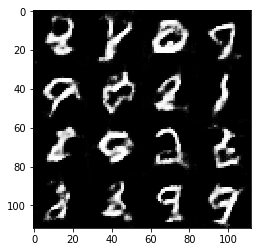

Epoch 1/2... Discriminator Loss: 1.2098... Generator Loss: 0.9415
Epoch 1/2... Discriminator Loss: 1.1763... Generator Loss: 0.9798
Epoch 1/2... Discriminator Loss: 1.0408... Generator Loss: 1.3556
Epoch 1/2... Discriminator Loss: 1.6999... Generator Loss: 0.4673
Epoch 1/2... Discriminator Loss: 1.0472... Generator Loss: 1.6445
Epoch 1/2... Discriminator Loss: 1.1231... Generator Loss: 0.9199
Epoch 1/2... Discriminator Loss: 1.0978... Generator Loss: 0.8830
Epoch 1/2... Discriminator Loss: 1.1117... Generator Loss: 1.7497
Epoch 1/2... Discriminator Loss: 0.9561... Generator Loss: 1.3639
Epoch 1/2... Discriminator Loss: 1.2746... Generator Loss: 0.9324


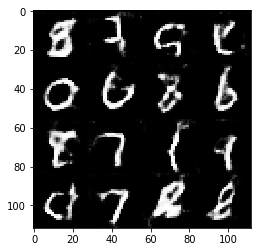

Epoch 1/2... Discriminator Loss: 1.3217... Generator Loss: 1.0371
Epoch 1/2... Discriminator Loss: 1.3952... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.1032... Generator Loss: 1.4754
Epoch 1/2... Discriminator Loss: 1.1634... Generator Loss: 0.7973
Epoch 1/2... Discriminator Loss: 1.2440... Generator Loss: 1.6349
Epoch 1/2... Discriminator Loss: 1.1412... Generator Loss: 1.4058
Epoch 1/2... Discriminator Loss: 1.0321... Generator Loss: 1.5705
Epoch 1/2... Discriminator Loss: 0.9737... Generator Loss: 1.2062
Epoch 1/2... Discriminator Loss: 1.0174... Generator Loss: 1.1270
Epoch 1/2... Discriminator Loss: 1.1394... Generator Loss: 1.6978


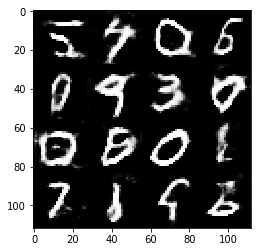

Epoch 1/2... Discriminator Loss: 1.3264... Generator Loss: 2.1325
Epoch 1/2... Discriminator Loss: 1.0061... Generator Loss: 1.5698
Epoch 1/2... Discriminator Loss: 1.1299... Generator Loss: 0.7941
Epoch 1/2... Discriminator Loss: 1.1984... Generator Loss: 0.8733
Epoch 1/2... Discriminator Loss: 1.1942... Generator Loss: 1.3885
Epoch 1/2... Discriminator Loss: 1.2434... Generator Loss: 1.4136
Epoch 1/2... Discriminator Loss: 1.2633... Generator Loss: 1.4481
Epoch 1/2... Discriminator Loss: 1.1932... Generator Loss: 1.1885
Epoch 1/2... Discriminator Loss: 1.2801... Generator Loss: 2.2725
Epoch 1/2... Discriminator Loss: 1.2949... Generator Loss: 0.6827


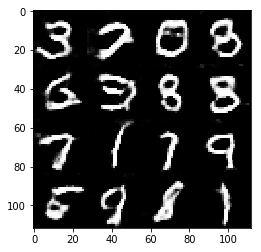

Epoch 1/2... Discriminator Loss: 1.0562... Generator Loss: 1.5463
Epoch 1/2... Discriminator Loss: 1.0156... Generator Loss: 1.7331
Epoch 1/2... Discriminator Loss: 1.0494... Generator Loss: 1.7342
Epoch 1/2... Discriminator Loss: 1.1470... Generator Loss: 1.0111
Epoch 1/2... Discriminator Loss: 0.9532... Generator Loss: 1.4198
Epoch 1/2... Discriminator Loss: 1.1636... Generator Loss: 1.0275
Epoch 1/2... Discriminator Loss: 1.6175... Generator Loss: 0.6435
Epoch 1/2... Discriminator Loss: 1.1180... Generator Loss: 1.5618
Epoch 1/2... Discriminator Loss: 1.1132... Generator Loss: 1.6291
Epoch 1/2... Discriminator Loss: 1.0667... Generator Loss: 0.9863


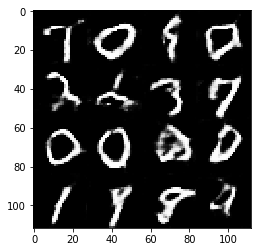

Epoch 1/2... Discriminator Loss: 1.2911... Generator Loss: 2.0285
Epoch 1/2... Discriminator Loss: 1.1377... Generator Loss: 1.5499
Epoch 1/2... Discriminator Loss: 1.1235... Generator Loss: 1.4878
Epoch 1/2... Discriminator Loss: 1.4221... Generator Loss: 0.5830
Epoch 1/2... Discriminator Loss: 1.1675... Generator Loss: 0.9995
Epoch 1/2... Discriminator Loss: 1.1773... Generator Loss: 1.7364
Epoch 1/2... Discriminator Loss: 1.0348... Generator Loss: 2.0446
Epoch 1/2... Discriminator Loss: 1.2346... Generator Loss: 0.9527
Epoch 1/2... Discriminator Loss: 1.1489... Generator Loss: 1.6122
Epoch 1/2... Discriminator Loss: 1.2380... Generator Loss: 0.7501


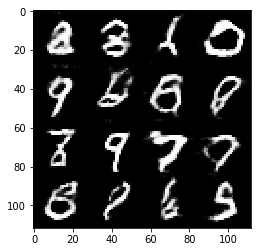

Epoch 1/2... Discriminator Loss: 1.3080... Generator Loss: 0.8543
Epoch 1/2... Discriminator Loss: 1.0121... Generator Loss: 1.7475
Epoch 1/2... Discriminator Loss: 1.0210... Generator Loss: 1.2039
Epoch 1/2... Discriminator Loss: 1.0972... Generator Loss: 1.1821
Epoch 1/2... Discriminator Loss: 1.0133... Generator Loss: 1.3874
Epoch 2/2... Discriminator Loss: 1.2460... Generator Loss: 1.7817
Epoch 2/2... Discriminator Loss: 1.5389... Generator Loss: 0.7847
Epoch 2/2... Discriminator Loss: 1.1225... Generator Loss: 1.2049
Epoch 2/2... Discriminator Loss: 1.1041... Generator Loss: 1.1054
Epoch 2/2... Discriminator Loss: 0.9287... Generator Loss: 1.5996


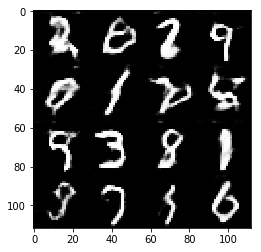

Epoch 2/2... Discriminator Loss: 1.0403... Generator Loss: 1.1730
Epoch 2/2... Discriminator Loss: 1.0355... Generator Loss: 1.2384
Epoch 2/2... Discriminator Loss: 1.4612... Generator Loss: 0.7496
Epoch 2/2... Discriminator Loss: 1.1577... Generator Loss: 1.0327
Epoch 2/2... Discriminator Loss: 1.1756... Generator Loss: 0.8080
Epoch 2/2... Discriminator Loss: 1.1512... Generator Loss: 0.8606
Epoch 2/2... Discriminator Loss: 1.1068... Generator Loss: 0.9483
Epoch 2/2... Discriminator Loss: 1.3285... Generator Loss: 0.9393
Epoch 2/2... Discriminator Loss: 1.1667... Generator Loss: 1.8176
Epoch 2/2... Discriminator Loss: 1.0750... Generator Loss: 1.8005


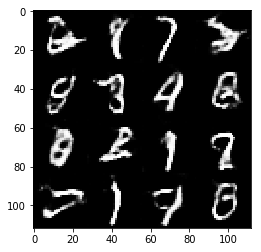

Epoch 2/2... Discriminator Loss: 1.0780... Generator Loss: 1.6956
Epoch 2/2... Discriminator Loss: 1.1210... Generator Loss: 1.3680
Epoch 2/2... Discriminator Loss: 1.2693... Generator Loss: 2.3866
Epoch 2/2... Discriminator Loss: 0.9539... Generator Loss: 0.9038
Epoch 2/2... Discriminator Loss: 1.2098... Generator Loss: 0.8858
Epoch 2/2... Discriminator Loss: 0.9640... Generator Loss: 1.2013
Epoch 2/2... Discriminator Loss: 1.1502... Generator Loss: 1.1426
Epoch 2/2... Discriminator Loss: 1.2344... Generator Loss: 1.1127
Epoch 2/2... Discriminator Loss: 1.2323... Generator Loss: 0.8560
Epoch 2/2... Discriminator Loss: 1.3321... Generator Loss: 0.8827


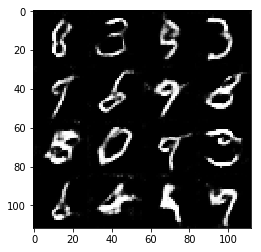

Epoch 2/2... Discriminator Loss: 1.1800... Generator Loss: 1.2783
Epoch 2/2... Discriminator Loss: 1.2436... Generator Loss: 0.7332
Epoch 2/2... Discriminator Loss: 1.2365... Generator Loss: 1.0337
Epoch 2/2... Discriminator Loss: 1.1020... Generator Loss: 1.1951
Epoch 2/2... Discriminator Loss: 1.5266... Generator Loss: 0.5864
Epoch 2/2... Discriminator Loss: 1.2651... Generator Loss: 2.1141
Epoch 2/2... Discriminator Loss: 1.2089... Generator Loss: 0.8059
Epoch 2/2... Discriminator Loss: 1.0486... Generator Loss: 1.1302
Epoch 2/2... Discriminator Loss: 1.1334... Generator Loss: 1.7759
Epoch 2/2... Discriminator Loss: 1.1011... Generator Loss: 1.1979


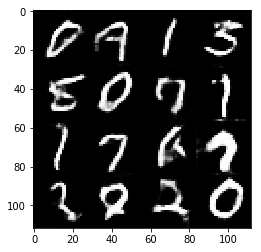

Epoch 2/2... Discriminator Loss: 1.0320... Generator Loss: 1.4880
Epoch 2/2... Discriminator Loss: 1.1887... Generator Loss: 1.0927
Epoch 2/2... Discriminator Loss: 0.9255... Generator Loss: 1.4247
Epoch 2/2... Discriminator Loss: 1.1374... Generator Loss: 1.9835
Epoch 2/2... Discriminator Loss: 1.1501... Generator Loss: 0.8173
Epoch 2/2... Discriminator Loss: 0.9988... Generator Loss: 1.4933
Epoch 2/2... Discriminator Loss: 1.1441... Generator Loss: 2.3113
Epoch 2/2... Discriminator Loss: 0.9395... Generator Loss: 1.3438
Epoch 2/2... Discriminator Loss: 0.9853... Generator Loss: 1.1625
Epoch 2/2... Discriminator Loss: 1.0629... Generator Loss: 1.4659


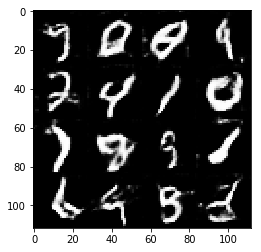

Epoch 2/2... Discriminator Loss: 0.9323... Generator Loss: 1.4040
Epoch 2/2... Discriminator Loss: 1.1535... Generator Loss: 0.9406
Epoch 2/2... Discriminator Loss: 1.0508... Generator Loss: 1.9346
Epoch 2/2... Discriminator Loss: 1.1058... Generator Loss: 1.6029
Epoch 2/2... Discriminator Loss: 1.2093... Generator Loss: 0.9889
Epoch 2/2... Discriminator Loss: 1.0914... Generator Loss: 1.3220
Epoch 2/2... Discriminator Loss: 1.0998... Generator Loss: 1.8677
Epoch 2/2... Discriminator Loss: 1.1687... Generator Loss: 2.6220
Epoch 2/2... Discriminator Loss: 1.1873... Generator Loss: 1.0216
Epoch 2/2... Discriminator Loss: 1.0080... Generator Loss: 1.0580


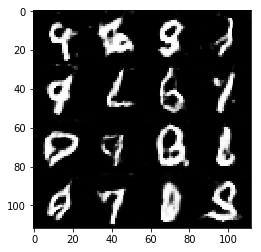

Epoch 2/2... Discriminator Loss: 1.2198... Generator Loss: 0.8943
Epoch 2/2... Discriminator Loss: 0.9574... Generator Loss: 1.4807
Epoch 2/2... Discriminator Loss: 1.0178... Generator Loss: 2.3435
Epoch 2/2... Discriminator Loss: 0.9572... Generator Loss: 1.1243
Epoch 2/2... Discriminator Loss: 0.9289... Generator Loss: 2.0405
Epoch 2/2... Discriminator Loss: 1.2351... Generator Loss: 1.7044
Epoch 2/2... Discriminator Loss: 1.1376... Generator Loss: 1.2437
Epoch 2/2... Discriminator Loss: 1.0149... Generator Loss: 1.8347
Epoch 2/2... Discriminator Loss: 0.9835... Generator Loss: 1.4585
Epoch 2/2... Discriminator Loss: 1.3012... Generator Loss: 0.6560


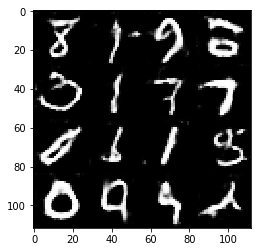

Epoch 2/2... Discriminator Loss: 1.1599... Generator Loss: 1.1201
Epoch 2/2... Discriminator Loss: 1.0856... Generator Loss: 0.8908
Epoch 2/2... Discriminator Loss: 1.1248... Generator Loss: 1.3335
Epoch 2/2... Discriminator Loss: 1.0672... Generator Loss: 1.5862
Epoch 2/2... Discriminator Loss: 1.1164... Generator Loss: 1.0156
Epoch 2/2... Discriminator Loss: 1.0144... Generator Loss: 1.5250
Epoch 2/2... Discriminator Loss: 1.1900... Generator Loss: 0.6904
Epoch 2/2... Discriminator Loss: 1.0110... Generator Loss: 1.7422
Epoch 2/2... Discriminator Loss: 1.1173... Generator Loss: 0.8499
Epoch 2/2... Discriminator Loss: 1.0027... Generator Loss: 2.2398


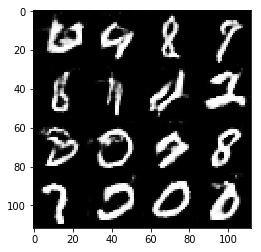

Epoch 2/2... Discriminator Loss: 1.1836... Generator Loss: 2.0937
Epoch 2/2... Discriminator Loss: 0.9445... Generator Loss: 1.5944
Epoch 2/2... Discriminator Loss: 1.0773... Generator Loss: 1.0688
Epoch 2/2... Discriminator Loss: 1.0539... Generator Loss: 1.0458
Epoch 2/2... Discriminator Loss: 1.0425... Generator Loss: 1.0811
Epoch 2/2... Discriminator Loss: 1.2763... Generator Loss: 0.6840
Epoch 2/2... Discriminator Loss: 1.1727... Generator Loss: 1.2676
Epoch 2/2... Discriminator Loss: 1.0948... Generator Loss: 0.9184
Epoch 2/2... Discriminator Loss: 1.1143... Generator Loss: 1.2558
Epoch 2/2... Discriminator Loss: 1.0749... Generator Loss: 1.4190


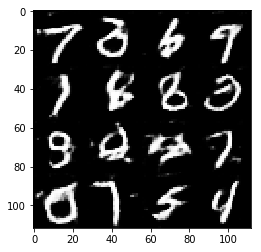

Epoch 2/2... Discriminator Loss: 0.9230... Generator Loss: 1.5400
Epoch 2/2... Discriminator Loss: 0.9517... Generator Loss: 1.1735
Epoch 2/2... Discriminator Loss: 0.8799... Generator Loss: 1.2795
Epoch 2/2... Discriminator Loss: 1.7218... Generator Loss: 3.2375
Epoch 2/2... Discriminator Loss: 1.0760... Generator Loss: 1.1571
Epoch 2/2... Discriminator Loss: 0.9941... Generator Loss: 1.2225
Epoch 2/2... Discriminator Loss: 1.0838... Generator Loss: 1.1975
Epoch 2/2... Discriminator Loss: 0.7805... Generator Loss: 1.4389
Epoch 2/2... Discriminator Loss: 1.2952... Generator Loss: 1.0480
Epoch 2/2... Discriminator Loss: 1.0640... Generator Loss: 0.9916


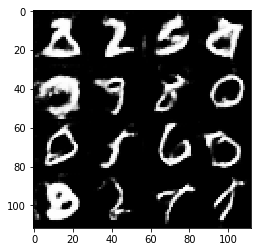

Epoch 2/2... Discriminator Loss: 1.1463... Generator Loss: 1.8185
Epoch 2/2... Discriminator Loss: 1.0584... Generator Loss: 1.5872
Epoch 2/2... Discriminator Loss: 0.8912... Generator Loss: 1.1997
Epoch 2/2... Discriminator Loss: 1.1341... Generator Loss: 0.9626
Epoch 2/2... Discriminator Loss: 0.9078... Generator Loss: 1.2742
Epoch 2/2... Discriminator Loss: 1.1626... Generator Loss: 1.7968
Epoch 2/2... Discriminator Loss: 0.9052... Generator Loss: 1.1663
Epoch 2/2... Discriminator Loss: 1.0072... Generator Loss: 1.4195
Epoch 2/2... Discriminator Loss: 1.1076... Generator Loss: 1.9141
Epoch 2/2... Discriminator Loss: 1.1332... Generator Loss: 1.0243


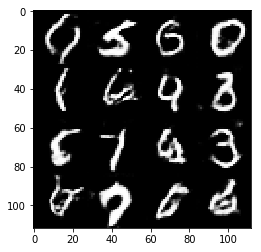

Epoch 2/2... Discriminator Loss: 1.0390... Generator Loss: 1.1157
Epoch 2/2... Discriminator Loss: 1.3033... Generator Loss: 0.8694
Epoch 2/2... Discriminator Loss: 1.0378... Generator Loss: 1.5220
Epoch 2/2... Discriminator Loss: 0.7638... Generator Loss: 1.6700
Epoch 2/2... Discriminator Loss: 0.8911... Generator Loss: 1.4284
Epoch 2/2... Discriminator Loss: 1.2118... Generator Loss: 1.0551
Epoch 2/2... Discriminator Loss: 1.2580... Generator Loss: 0.8250
Epoch 2/2... Discriminator Loss: 1.3272... Generator Loss: 0.7667
Epoch 2/2... Discriminator Loss: 1.1588... Generator Loss: 1.3297
Epoch 2/2... Discriminator Loss: 0.9928... Generator Loss: 1.3798


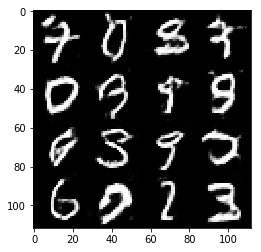

Epoch 2/2... Discriminator Loss: 1.2091... Generator Loss: 1.1473
Epoch 2/2... Discriminator Loss: 0.8734... Generator Loss: 1.8689
Epoch 2/2... Discriminator Loss: 1.0479... Generator Loss: 1.9886
Epoch 2/2... Discriminator Loss: 1.0627... Generator Loss: 0.8548
Epoch 2/2... Discriminator Loss: 1.1633... Generator Loss: 2.0336
Epoch 2/2... Discriminator Loss: 1.1597... Generator Loss: 1.0535
Epoch 2/2... Discriminator Loss: 1.1347... Generator Loss: 1.3158
Epoch 2/2... Discriminator Loss: 1.0125... Generator Loss: 2.0802
Epoch 2/2... Discriminator Loss: 1.2164... Generator Loss: 0.9201
Epoch 2/2... Discriminator Loss: 1.0726... Generator Loss: 2.0192


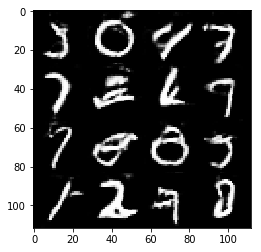

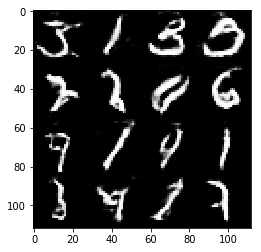

Done


In [ ]:
batch_size = 48
z_dim = 50
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.